some UPC -> 341776144100, 7410811099, 25541500000

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import pylab as pl
import sklearn.cross_validation, sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from scipy.sparse import csc_matrix
import xgboost as xgb
import gc

%matplotlib inline
pd.set_option('display.mpl_style', 'default')
pl.rcParams['figure.figsize'] = (20, 10)

column_dtypes = {'ScanCount': 'int8'}

train = pd.read_csv('train.csv', low_memory=False, dtype=column_dtypes)
test = pd.read_csv('test.csv', low_memory=False, dtype=column_dtypes)
types = np.unique(train.TripType.values)
types_dictionary = {t: i for i, t in  enumerate(types)}

In [15]:
def transform_Upc_len12(upc): 
    if upc // 10**11 % 10 != 0:
        return upc // 10
    else:
        return upc

def transform_Upc(data):
    data.Upc = data.Upc.map(lambda x: transform_Upc_len12(x))
    for i in range(1,12):
        data['Upc_' + str(i)] = (data.Upc // 10**(12 - i - 1) % 10).astype('int8')
        data['UpcManufacturer'] = ((data.Upc // 10**5) - (data.Upc // 10**10)*10**5).astype('int32')
        data['UpcProduct'] = (data.Upc % 10**5).astype('int32')
    return data

def preprocess_columns(data):
    data.Upc = data.Upc.fillna(0).astype('int64')
    data.FinelineNumber = data.FinelineNumber.fillna(10000).astype('int16')
    data.DepartmentDescription = data.DepartmentDescription.fillna('UNKNOWN')
    data = transform_Upc(data)
    return data

train = preprocess_columns(train)
test = preprocess_columns(test)


In [16]:
def compute_checksum_UPC(upc):
    assert len(upc) == 11
    res = sum([int(digit) for i, digit in enumerate(upc) if i % 2 == 0])*3
    res += sum([int(digit) for i, digit in enumerate(upc) if i % 2 == 1])
    res = 10 - (res % 10)
    if res == 10:
        res = 0
    return res
    
def checksum_UPC(upc):
    assert len(upc) == 12
    res = compute_checksum_UPC(upc[:-1])
    return res == int(upc[-1])

In [65]:
def get_frequence_feature(feature):
    dict_counts = dict(feature.value_counts())
    series = feature.map(lambda x: dict_counts[x])
    return (series - series.min())/(series.max() - series.min())

def most_freq_dummies(feature, feature_freq, threshold=0.2):
    mask = feature_freq >= threshold
    to_dummies = np.unique((feature + 1).multiply(mask).values)
    return (to_dummies - 1)[1:]
    

def encode_features(data):
    to_dummies = {}
    data['FinelineNumberFreq'] = get_frequence_feature(data.FinelineNumber)
    to_dummies['FinelineNumber'] = most_freq_dummies(data.FinelineNumber, data.FinelineNumberFreq, threshold=0.1)
    
    data['UpcManufacturerFreq'] = get_frequence_feature(data.UpcManufacturer)
    to_dummies['UpcManufacturer'] = most_freq_dummies(data.UpcManufacturer, data.UpcManufacturerFreq, threshold=0.016)
    
    data['UpcProductFreq'] = get_frequence_feature(data.UpcProduct)
    to_dummies['UpcProduct'] = most_freq_dummies(data.UpcProduct, data.UpcProductFreq, threshold=0.04)
    
    data['DepartmentFreq'] = get_frequence_feature(data.DepartmentDescription)
    data['UpcFreq'] = get_frequence_feature(data.Upc)
    
    return data, to_dummies

data = train.append(test)
data, to_dummies = encode_features(data)
train = data[:len(train)]
test = data[len(train):]

del data, test['TripType']

In [18]:
def at(l):
    return l.iloc[0]
def mklist(l):
    return list(l)

columns = ['TripType', 'Weekday', 'DepartmentDescription', 'DepartmentFreq']
columns_complement = [col for col in train.columns if col not in columns + ['VisitNumber']]
agg_dict = {col:at for col in columns}
agg_dict.update({col:mklist for col in columns_complement})

train_grouped = train.groupby('VisitNumber').agg(agg_dict).reset_index()    
agg_dict.pop("TripType", None)
test_grouped = test.groupby('VisitNumber').agg(agg_dict).reset_index()

for column in columns_complement:
    train_grouped[column] = train_grouped[column].map(lambda x: np.array(x))
    test_grouped[column] = test_grouped[column].map(lambda x: np.array(x))

del agg_dict, columns, columns_complement
gc.collect()

7

In [197]:
def construct_grouped_features(data):
    
    data['LogNumberOfReturned'] = data.ScanCount.map(lambda x: np.log(-sum([a for a in x if a < 0]) + 1))
    data['LogNumberOfPurchased'] = data.ScanCount.map(lambda x: np.log(sum([a for a in x if a > 0]) + 1))
    data['MedianScanCount'] = data.ScanCount.map(lambda x: np.median(x))
    data['StdScanCount'] = data.ScanCount.map(lambda x: np.max(x))
    
    data['ModeFinelineNumber'] = data.FinelineNumber.map(lambda x: np.argmax(np.bincount(x)))
    data['ModeUpcManufacturer'] = data.UpcManufacturer.map(lambda x: np.argmax(np.bincount(x)))
    data['ModeUpcProduct'] = data.UpcProduct.map(lambda x: np.argmax(np.bincount(x)))
    
    data['MedianUpcManufacturer'] = data.UpcManufacturer.map(lambda x: np.median(x))
    data['MedianUpc'] = data.Upc.map(lambda x: np.median(x))
    
    data['MeanDiffUMrUpt'] = (data.UpcManufacturerFreq - data.UpcProductFreq).map(lambda x: np.mean(x))
    data['MeanDiffFlNUMr'] = (data.FinelineNumberFreq - data.UpcManufacturerFreq).map(lambda x: np.mean(x))
    
    data['SumSnCtFlNFreq'] = (data.FinelineNumberFreq*data.ScanCount).map(lambda x: np.sum(x))
    data['SumSnCtUPtFreq'] = (data.UpcProductFreq*data.ScanCount).map(lambda x: np.sum(x))
    data['SumSnCtUMrFreq'] = (data.UpcManufacturerFreq*data.ScanCount).map(lambda x: np.sum(x))
    data['SumSnCtUpcFreq'] = (data.UpcFreq*data.ScanCount).map(lambda x: np.sum(x))
    
    data['MedianSnCtFlNFreq'] = (data.FinelineNumberFreq*data.ScanCount).map(lambda x: np.median(x))
    data['MedianSnCtUPtFreq'] = (data.UpcProductFreq*data.ScanCount).map(lambda x: np.median(x))
    data['MedianSnCtUMrFreq'] = (data.UpcManufacturerFreq*data.ScanCount).map(lambda x: np.median(x))
    data['MedianSnCtUpcFreq'] = (data.UpcFreq*data.ScanCount).map(lambda x: np.median(x))
    
    data['StdSnCtFlNFreq'] = (data.FinelineNumberFreq*data.ScanCount).map(lambda x: np.std(x))
    data['StdSnCtUPtFreq'] = (data.UpcProductFreq*data.ScanCount).map(lambda x: np.std(x))
    data['StdSnCtUMrFreq'] = (data.UpcManufacturerFreq*data.ScanCount).map(lambda x: np.std(x))
    data['StdSnCtUpcFreq'] = (data.UpcFreq*data.ScanCount).map(lambda x: np.std(x))
    
    
    data['MedianFlNnUptnUMr'] = (data.UpcProductFreq + data.UpcManufacturerFreq +
                                 data.FinelineNumberFreq).map(lambda x: np.median(x))
    data['StdFlNnUptnUMr'] = (data.UpcProductFreq + data.UpcManufacturerFreq +
                                 data.FinelineNumberFreq).map(lambda x: np.std(x))
    
    return data

train_grouped = construct_grouped_features(train_grouped)

test_grouped = construct_grouped_features(test_grouped)
gc.collect()

35848

#####Plotting distribution of generated features

41, 29, 43, 18, 44, 26 - need to watch

8397

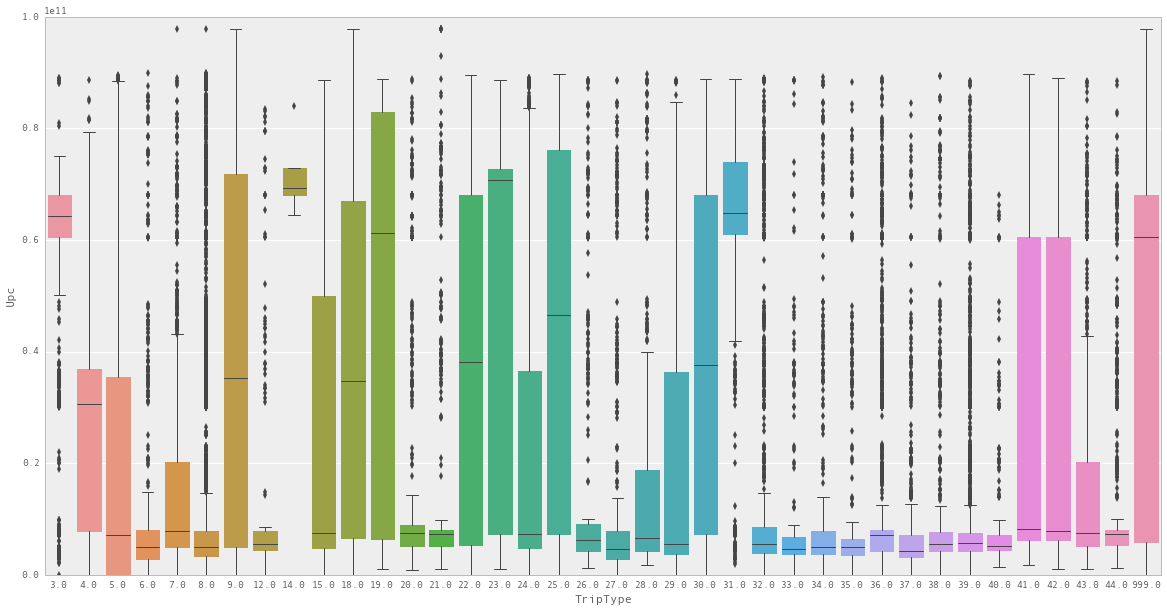

In [199]:
temp = train_grouped.sort('TripType')
temp_feature = (temp.Upc).map(lambda x: np.median(x))
sns.boxplot(temp.TripType, temp_feature)
del temp, temp_feature
gc.collect()

In [200]:
def construct_dummy_features(data, dummy_columns):
    data = pd.get_dummies(data, sparse=True, dummy_na=False, columns=dummy_columns)
    return data

def construct_pseudo_dummy_features(data, to_dummies):
    for i in range(10):
        data['Upc_1_value' + str(i)] = data['Upc_1'].map(lambda x: (i == x).sum()/len(x))
    
    for elem in to_dummies['FinelineNumber']:
        data['FlNDummy_' + str(elem)] = data.FinelineNumber.map(lambda x: (elem == x).sum()/len(x))
    for elem in to_dummies['UpcManufacturer']:
        data['UMrDummy_' + str(elem)] = data.UpcManufacturer.map(lambda x: (elem == x).sum()/len(x))
    for elem in to_dummies['UpcProduct']:
        data['UPtDummy_' + str(elem)] = data.UpcProduct.map(lambda x: (elem == x).sum()/len(x))
        
    for i in list(range(1,5)):
        data['ScanCount_' + str(i)] = data.ScanCount.map(lambda x: (i == x).sum()/len(x))
    return data

In [201]:
features_excluded = ['UpcManufacturerFreq', 'UpcManufacturer', 'UpcProductFreq', 'UpcProduct', 'FinelineNumberFreq',
                     'ScanCount', 'Upc', 'UpcFreq', 'FinelineNumber'] + ['Upc_' + str(i) for i in range(1,12)]

data = train_grouped.append(test_grouped)
data = construct_pseudo_dummy_features(data, to_dummies)

data = data[[col for col in data.columns if col not in features_excluded]]
columns = [col for col in data.columns 
           if col not in ['DepartmentDescription', 'Weekday', 'TripType'] + features_excluded]

data = construct_dummy_features(data, ['Weekday', 'DepartmentDescription'])

train_dummies = data.iloc[:len(train_grouped)]
test_dummies = data.iloc[len(train_grouped):]
del data, test_dummies['TripType']
print(len(test_dummies.columns), 'features constructed')
print('Memory usage of dataframe train_dummies is %3.2f Mb' % (train_dummies.memory_usage(index=True).sum()/2**20))
print('Memory usage of dataframe test_dummies is %3.2f Mb' % (test_dummies.memory_usage(index=True).sum()/2**20))
gc.collect()

388 features constructed
Memory usage of dataframe train_dummies is 230.66 Mb
Memory usage of dataframe test_dummies is 229.93 Mb


35855

In [23]:
# del train, test, train_grouped, test_grouped

In [191]:
def get_prior_probabilities(data):
    prior_probabilities = np.zeros(len(types))
    prior_probabilities += np.array([len(data[data.TripType == trip_type]) for trip_type in types])
    prior_probabilities /= prior_probabilities.sum()
    return prior_probabilities

In [192]:
def fit_predict(train_array, train_labels, test_array, prior_probabilities=None, algorithm='rf', alpha=None, 
                plot_importance=True, feature_names=None, random_state=None):
    if algorithm == 'xgb':
        clf = xgb.XGBClassifier(n_estimators=105, max_depth=12, learning_rate=0.1, objective='multi:softprob', 
                                colsample_bytree=0.3, subsample=0.9, seed=random_state)
        clf.fit(train_array, train_labels)
        prediction_matrix = clf.predict_proba(test_array)
        
        if plot_importance and feature_names:
            with open('xgb.fmap', 'w') as outfile:
                for i, feature_name in enumerate(feature_names):
                    outfile.write('{0}\t{1}\tq\n'.format(i, feature_name))
            importances = clf.booster().get_fscore('xgb.fmap')
            feature_names = list(importances.keys())
            importances = np.array(list(importances.values()))
            pl.title('Feature Importance')
            sorted_indices = np.argsort(importances)[::-1]
            for i, k in enumerate(sorted_indices):
                print('%2d (feature %2d):' % (i, k), feature_names[k], 'Value = %.5f' % importances[k])
            print([feature_names[k] for k in sorted_indices])
            sns.barplot(np.arange(len(feature_names)), importances[sorted_indices], color='r')
                        
    elif algorithm in ['rf']:
        if algorithm == 'rf':
            clf = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=1, max_features=0.2,
                                         n_jobs=-1, random_state=random_state)
        clf.fit(train_array, train_labels)
        prediction_matrix = clf.predict_proba(test_array)
        if plot_importance and feature_names:
            importances = clf.feature_importances_
            std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
            pl.title('Feature Importance')
            sorted_indices = np.argsort(importances)[::-1]
            for i, k in enumerate(sorted_indices):
                print('%2d (feature %2d):' % (i, k), feature_names[k], 'Value = %.5f' % importances[k])
            print([feature_names[k] for k in sorted_indices])

            pl.bar(range(len(feature_names)), importances[sorted_indices], color='r',
                   yerr=std[sorted_indices], align='center')
            pl.xticks(range(len(feature_names)), sorted_indices)
            pl.xlim([-1, len(feature_names) + 1])
    
    elif algorithm in ['logit', 'sgd']:
        if algorithm == 'logit':
            clf = LogisticRegressionCV(Cs=5, n_jobs=-1, random_state=random_state)
        elif algorithm == 'sgd':
            clf = SGDClassifier(loss='log', n_jobs=-1, alpha=10**6, class_weight='balanced', random_state=random_state)
        clf.fit(train_array, train_labels)
        prediction_matrix = clf.predict_proba(test_array)
        
    if not prior_probabilities is None:
        coeff = 0.1
        prediction_matrix = (prediction_matrix + [prior_probabilities*coeff]*len(prediction_matrix))/(1. + coeff)
    return prediction_matrix

In [193]:
def train_and_score(train_dummies, grid_space=[0], algorithm='rf', plot_importance=True, plot_errors=True, random_state=None):
    if len(grid_space) > 1:
        alphas, scores = [], []
        min_alpha, min_score = 1., 10**5
        random_state = 14525

    for alpha in grid_space:
        if len(grid_space) > 1:
            print('alpha =', alpha)
        y = train_dummies.TripType.values
        for train_indices, test_indices in sklearn.cross_validation.StratifiedShuffleSplit(y, n_iter=1, test_size=0.1, 
                                                                                           random_state=random_state):
            data_train = train_dummies.iloc[train_indices]
            data_test = train_dummies.iloc[test_indices]

    #         prior_probabilities = get_prior_probabilities(data_train)
            feature_names = [col for col in data_train.columns if col not in ['TripType']]
            
            prediction_matrix = fit_predict(csc_matrix(data_train[feature_names].values), 
                                            data_train.TripType.values, 
                                            csc_matrix(data_test[feature_names].values), 
                                            algorithm=algorithm, alpha=alpha, plot_importance=plot_importance, 
                                            feature_names=feature_names, random_state=random_state)
            
            prediction_matrix = np.delete(prediction_matrix, 7, axis=1)
            y_true = data_test.TripType.values
            
            mlogloss = sklearn.metrics.log_loss(y_true, prediction_matrix) 
            
            print('mlogloss =', mlogloss, end='\n\n')
            if plot_errors:
                pl.figure()
                df = pd.DataFrame(y_true, columns=['TripType'])
                df['PredictedProba'] = 0
                for i, y in enumerate(np.unique(y_true)):
                    df.ix[df.TripType == y, 'PredictedProba'] = prediction_matrix[y_true == y, i]
                f, ax = pl.subplots()
                df = df.sort('TripType')
                sns.boxplot(df.TripType, df.PredictedProba, ax=ax)
                f.savefig('proba_errors.png')
            
            if len(grid_space) > 1:
                alphas.append(alpha)
                scores.append(mlogloss)
                if mlogloss <= min_score:
                    min_score = mlogloss
                    min_alpha = alpha
    if len(grid_space) > 1:
        return alphas, scores, min_alpha, min_score
    else:
        return mlogloss

##MAIN

In [27]:
# train_dump = train_dummies
# test_dump = test_dummies

In [28]:
# feature_selection = ['ModeFinelineNumber', 'VisitNumber', 'MedianFinelineNumberFreq', 'ModeUpcProduct', 'MedianFlNnUptnUMr', 'SumSnCtFlNFreq', 'MedianUpcManufacturerFreq', 'SumSnCtUPtFreq', 'SumSnCtUMrFreq', 'MedianUpcProductFreq', 'StdSnCtFlNFreq', 'MeanDiffUMrUpt', 'MaxFlNnUptnUMr', 'ModeUpcManufacturer', 'StdRelUMrUpt', 'StdSnCtUMrFreq', 'StdSnCtUPtFreq', 'DepartmentFreq', 'Upc_1_value0', 'LogNumberOfPurchased', 'Upc_1_value6', 'Upc_1_value8', 'Upc_1_value7', 'MaxScanCount', 'UMrDummy_81131', 'UMrDummy_78742', 'UMrDummy_0', 'Upc_1_value3', 'UMrDummy_37000', 'UMrDummy_5388', 'UMrDummy_49000', 'Weekday_Saturday', 'Weekday_Sunday', 'UMrDummy_28400', 'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Friday', 'UMrDummy_35000', 'Weekday_Wednesday', 'Weekday_Thursday', 'MedianScanCount', 'UMrDummy_34000', 'FlNDummy_135', 'UMrDummy_33383', 'Upc_1_value2', 'LogNumberOfReturned', 'FlNDummy_5501', 'UPtDummy_0', 'UPtDummy_4011', 'UMrDummy_44000', 'UMrDummy_38000', 'FlNDummy_0', 'DepartmentDescription_DSD GROCERY', 'FlNDummy_808', 'FlNDummy_1508', 'FlNDummy_115', 'DepartmentDescription_IMPULSE MERCHANDISE', 'FlNDummy_9546', 'UPtDummy_62097', 'FlNDummy_100', 'DepartmentDescription_PERSONAL CARE', 'DepartmentDescription_PRODUCE', 'DepartmentDescription_PHARMACY OTC', 'FlNDummy_203', 'FlNDummy_202', 'FlNDummy_3004', 'FlNDummy_801', 'FlNDummy_4010', 'FlNDummy_110', 'FlNDummy_1407', 'Upc_1_value4', 'FlNDummy_4606', 'FlNDummy_10000', 'DepartmentDescription_DAIRY', 'FlNDummy_3467', 'FlNDummy_5017', 'FlNDummy_3601', 'FlNDummy_5620', 'DepartmentDescription_GROCERY DRY GOODS', 'FlNDummy_8101', 'DepartmentDescription_FROZEN FOODS', 'DepartmentDescription_BEAUTY', 'DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP', 'FlNDummy_3600', 'FlNDummy_7010', 'FlNDummy_3555', 'FlNDummy_9100', 'DepartmentDescription_MENS WEAR', 'UPtDummy_35186', 'FlNDummy_3702', 'FlNDummy_7955', 'FlNDummy_9570', 'UPtDummy_35187', 'DepartmentDescription_CANDY, TOBACCO, COOKIES', 'FlNDummy_4624', 'UPtDummy_44', 'FlNDummy_9101', 'DepartmentDescription_CELEBRATION', 'DepartmentDescription_HOUSEHOLD PAPER GOODS', 'UPtDummy_20027', 'UPtDummy_4087', 'FlNDummy_3120', 'UPtDummy_4046', 'DepartmentDescription_COMM BREAD', 'DepartmentDescription_PETS AND SUPPLIES', 'DepartmentDescription_BAKERY', 'UPtDummy_7862', 'DepartmentDescription_SERVICE DELI', 'DepartmentDescription_HOME MANAGEMENT', 'DepartmentDescription_COOK AND DINE', 'DepartmentDescription_OFFICE SUPPLIES', 'DepartmentDescription_FINANCIAL SERVICES', 'DepartmentDescription_HARDWARE', 'DepartmentDescription_AUTOMOTIVE', 'UPtDummy_71457', 'UPtDummy_4062', 'UPtDummy_71461', 'DepartmentDescription_LADIESWEAR', 'DepartmentDescription_INFANT CONSUMABLE HARDLINES', 'DepartmentDescription_SPORTING GOODS', 'DepartmentDescription_TOYS', 'DepartmentDescription_LIQUOR,WINE,BEER', 'DepartmentDescription_LAWN AND GARDEN', 'DepartmentDescription_SHOES']
# train_dummies = train_dump[feature_selection + ['TripType']]
# test_dummies = test_dump[feature_selection]

In [29]:
# train_dummies = train_dump
# test_dummies = test_dump
# del train_dump, test_dump

/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


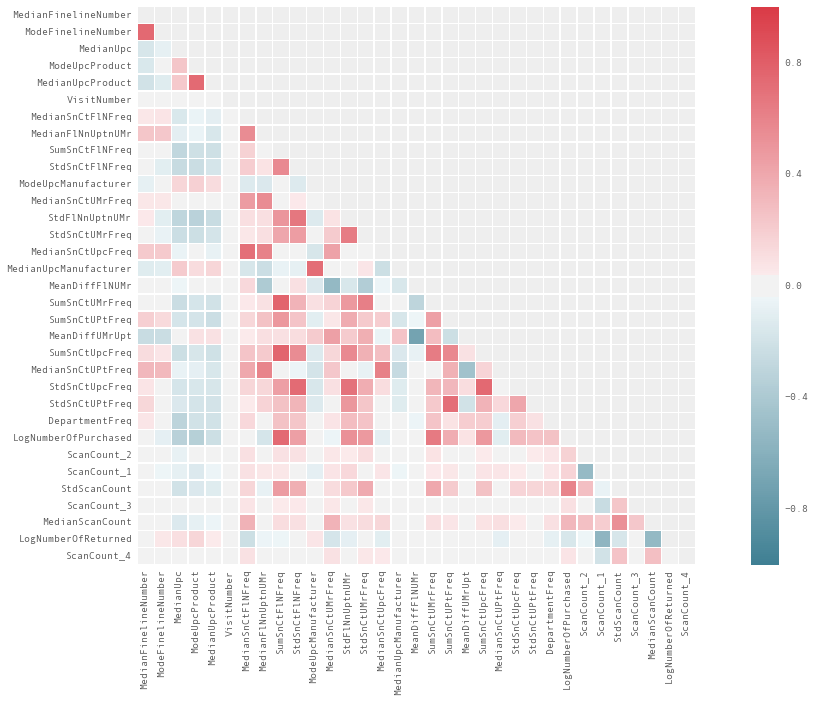

In [205]:
columns = [col for col in test_dummies.columns 
           if not np.any([col.startswith(s) for s in ['FlNDummy','UMrDummy','UPtDummy','DepartmentDescription', 'Weekday', 'Upc_']])]
corr = train_dummies[columns].append(test_dummies[columns]).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, robust=True, linewidths=0.2, annot=False)
del corr, mask, cmap, columns

 0 (feature 49): MedianFinelineNumber Value = 25405.00000
 1 (feature 32): ModeFinelineNumber Value = 24933.00000
 2 (feature 362): MedianUpc Value = 22739.00000
 3 (feature 205): ModeUpcProduct Value = 22471.00000
 4 (feature 310): MedianUpcProduct Value = 22360.00000
 5 (feature 114): VisitNumber Value = 22126.00000
 6 (feature 146): MedianSnCtFlNFreq Value = 21229.00000
 7 (feature 334): MedianFlNnUptnUMr Value = 20404.00000
 8 (feature  5): SumSnCtFlNFreq Value = 19783.00000
 9 (feature 363): StdSnCtFlNFreq Value = 19765.00000
10 (feature 203): ModeUpcManufacturer Value = 19651.00000
11 (feature 351): MedianSnCtUMrFreq Value = 19265.00000
12 (feature 61): StdFlNnUptnUMr Value = 19202.00000
13 (feature 18): StdSnCtUMrFreq Value = 19105.00000
14 (feature 88): MedianSnCtUpcFreq Value = 19077.00000
15 (feature 371): MedianUpcManufacturer Value = 19068.00000
16 (feature 246): MeanDiffFlNUMr Value = 18942.00000
17 (feature 367): SumSnCtUMrFreq Value = 18078.00000
18 (feature 134): SumSnC

896

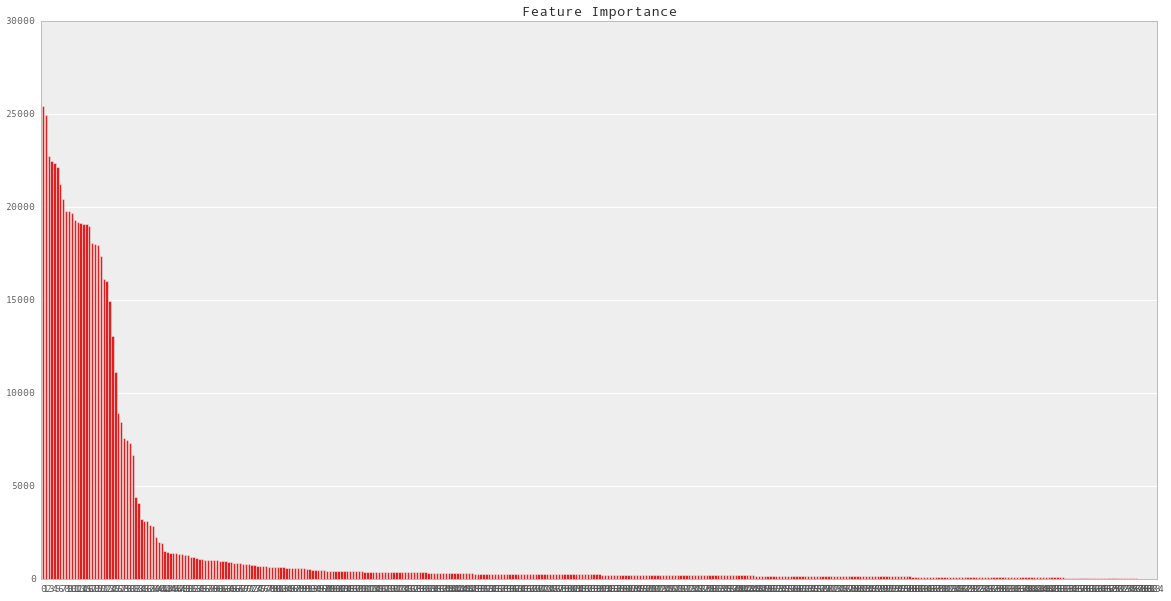

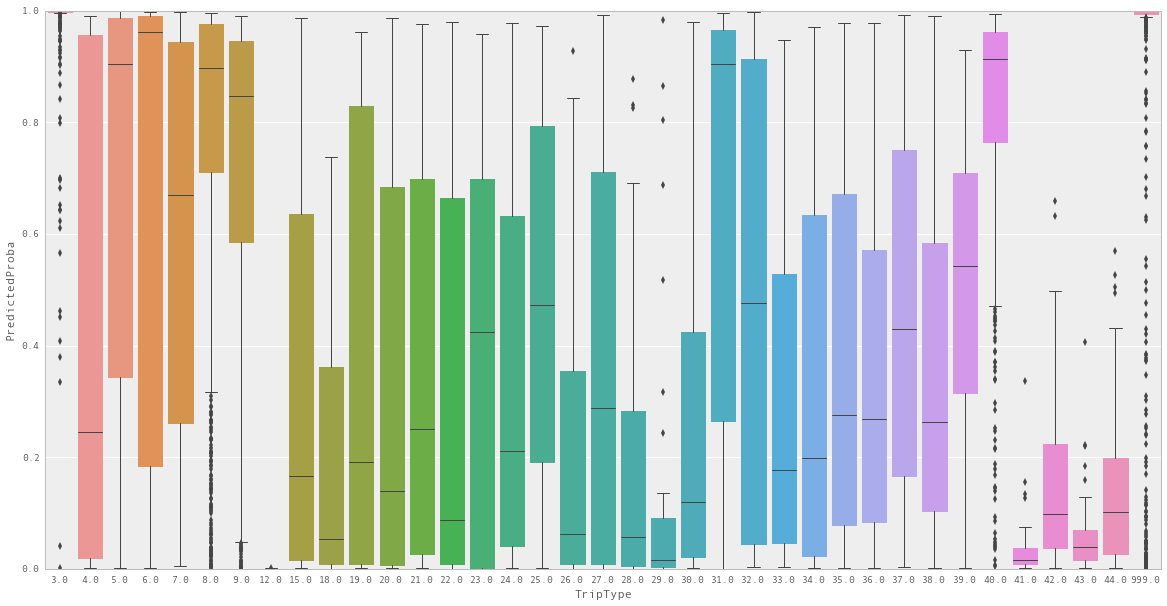

In [204]:
algorithms = ['rf', 'xgb', 'logit', 'sgd']
algorithm = 'xgb'

validation = True

if validation:
    
    compute_optimal = False
    if compute_optimal:
        grid_space = np.arange(0.4, 0.8, 0.1)
        alphas, scores, min_alpha, min_score = train_and_score(train_dummies, grid_space=grid_space,
                                                               algorithm=algorithm, plot_importance=False,
                                                               plot_errors=False)
        print('MIN ALPHA =', min_alpha, 'MIN_MLOGLOSS =', min_score)
        pl.figure()
        pl.plot(alphas, scores, 'r.--')
    else:
        mlogloss = train_and_score(train_dummies, algorithm=algorithm)
    
elif not validation:
#     prior_probabilities = get_prior_probabilities(train)
    prediction_matrix = fit_predict(csc_matrix(train_dummies[[col for col in test_dummies.columns]].values), 
                                    train_dummies.TripType.values, csc_matrix(test_dummies.values), algorithm=algorithm)
    
    prediction_df = pd.DataFrame(prediction_matrix, columns=['TripType_' + str(i) for i in types])
    prediction_df['VisitNumber'] = test_dummies.VisitNumber.values
    
    prediction_df = prediction_df[['VisitNumber'] + [x for x in prediction_df.columns if x != 'VisitNumber']]
    del prediction_matrix
    
    filename = 'prediction.csv'
    prediction_df.to_csv(filename, index=False)
    print(filename, 'was created')
    del prediction_df

gc.collect()

41, 29, 43, 18, 44, 26 - need to watch